In [1]:
# ============================================================
# CELL 1: IMPORTS & SMALL UTILS
# ============================================================
import os
import sys
import gc
import math
import json
import shutil
from pathlib import Path
from typing import Dict, Any, Callable, List, Tuple
from dataclasses import dataclass

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas as pd
import polars as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from tqdm.auto import tqdm

from sklearn.decomposition import PCA
import joblib
import yaml

from transformers import (
    CLIPProcessor,
    CLIPModel,
    AutoTokenizer,
    AutoModel,
)

from sklearn.metrics import roc_auc_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

2025-12-19 18:12:15.897063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766167936.101133      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766167936.160426      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766167936.639905      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766167936.639939      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766167936.639942      24 computation_placer.cc:177] computation placer alr

Using device: cuda


In [2]:
# ============================================================
# CELL 2: CONFIG & BASIC SETUP
# ============================================================

@dataclass
class Paths:
    # Root of the competition dataset
    dataset_root: str = "/kaggle/input/www2025-mmctr-data/MicroLens_1M_MMCTR"
    DATA_ROOT = Path("/kaggle/input/www2025-mmctr-data/MicroLens_1M_MMCTR")
    
    # Original data folders
    item_images_dir: str = "/kaggle/input/www2025-mmctr-data/MicroLens_1M_MMCTR/item_images"
    item_info_path: str = "/kaggle/input/www2025-mmctr-data/MicroLens_1M_MMCTR/MicroLens_1M_x1/item_info.parquet"
    item_feature_path: str = "/kaggle/input/www2025-mmctr-data/MicroLens_1M_MMCTR/item_feature.parquet"
    item_seq_path: str = "/kaggle/input/www2025-mmctr-data/MicroLens_1M_MMCTR/item_seq.parquet"
    
    # Working directory (we'll write new files here)
    working_root: str = "/kaggle/working/mmctr_task1_v2"
    WORKING = Path("/kaggle/working/mmctr_task1_v2")
    
    # Where the baseline repo will live
    baseline_repo_dir: str = "/kaggle/working/WWW2025_MMCTR_Challenge"
    
    # Path to the data folder *inside* the baseline repo (adjust if different)
    baseline_data_dir: str = "/kaggle/working/WWW2025_MMCTR_Challenge/data/MicroLens_1M_x1"
    
    # Output embeddings and PCA models
    img_emb_npy: str = "/kaggle/working/mmctr_task1_v2/item_img_emb_clipL_768.npy"
    txt_emb_npy: str = "/kaggle/working/mmctr_task1_v2/item_txt_emb_e5_768.npy"
    multimodal_emb_npy: str = "/kaggle/working/mmctr_task1_v2/item_mm_emb_128.npy"
    pca_model_path: str = "/kaggle/working/mmctr_task1_v2/pca_mm_128.joblib"

    # Model
    MAX_SEQ_LEN = 50
    D_ID_EMB = 64  # Trainable item ID embedding
    D_MM_EMB = 128  # Frozen multimodal from Task 1
    D_MODEL = D_ID_EMB + D_MM_EMB  # 192
    
    # Transformer
    NUM_LAYERS = 2
    NUM_HEADS = 4
    FFN_HIDDEN = 512
    DROPOUT = 0.1
    
    # DCN-v2
    NUM_CROSS = 3
    DNN_HIDDEN = [512, 256, 128]
    
    # Training
    BATCH_SIZE = 2048
    LR = 1e-3
    WEIGHT_DECAY = 1e-6
    EPOCHS = 20
    PATIENCE = 3
    GRAD_CLIP = 1.0
    
    # DataLoader
    NUM_WORKERS = 4
    PIN_MEMORY = True

P = Paths()

os.makedirs(P.working_root, exist_ok=True)

print("Working root:", P.working_root)

Working root: /kaggle/working/mmctr_task1_v2


In [3]:
# ============================================================
# CELL 3: HELPER FUNCTIONS
# ============================================================
def modify_yaml(path: str, fn: Callable[[Dict[str, Any]], Dict[str, Any]]) -> None:
    """Load a YAML file, apply a modifier function, and write it back."""
    with open(path, "r") as f:
        conf = yaml.safe_load(f)
    conf = fn(conf)
    with open(path, "w") as f:
        yaml.dump(conf, f, sort_keys=False)

def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def set_seed(seed: int = 42) -> None:
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
# ============================================================
# CELL 4: LOAD DATA & SANITY CHECKS
# ============================================================
item_info = pd.read_parquet(P.item_info_path)
item_feature = pd.read_parquet(P.item_feature_path)

print("item_info columns:", item_info.columns.tolist())
print("item_feature columns:", item_feature.columns.tolist())

print("item_info rows:", len(item_info))
print("item_feature rows:", len(item_feature))

# Check item_id ranges
print("item_info item_id range:", item_info["item_id"].min(), "->", item_info["item_id"].max())
print("item_feature item_id range:", item_feature["item_id"].min(), "->", item_feature["item_id"].max())

# Ensure uniqueness
assert item_info["item_id"].is_unique, "item_info.item_id must be unique"
# item_feature might have multiple rows per item depending on structure; we will aggregate if needed.

item_info columns: ['item_id', 'item_tags', 'item_emb_d128']
item_feature columns: ['item_id', 'item_title', 'item_tags', 'likes_level', 'views_level', 'txt_emb_BERT', 'img_emb_CLIPRN50']
item_info rows: 91718
item_feature rows: 91717
item_info item_id range: 0 -> 91717
item_feature item_id range: 1 -> 91717


In [5]:
# Canonical item_id list
item_ids = np.sort(item_info["item_id"].unique())
num_items = len(item_ids)
print("Number of items:", num_items)

item_id_to_idx = {iid: idx for idx, iid in enumerate(item_ids)}
idx_to_item_id = {idx: iid for iid, idx in item_id_to_idx.items()}

Number of items: 91718


In [6]:
# ============================================================
# CELL 5: IMAGE DATASET FOR CLIP
# ============================================================
class ItemImageDataset(Dataset):
    """
    Dataset that loads images by item_id.
    Assumes images are stored as {item_id}.jpg in item_images_dir.
    """
    def __init__(self, item_ids: np.ndarray, image_dir: str):
        self.item_ids = item_ids
        self.image_dir = image_dir
        # fallback blank image for missing/corrupted ones
        self.fallback_img = Image.new("RGB", (224, 224), color=(0, 0, 0))

    def __len__(self) -> int:
        return len(self.item_ids)

    def __getitem__(self, idx: int) -> Tuple[int, int, Image.Image]:
        item_id = int(self.item_ids[idx])
        img_path = os.path.join(self.image_dir, f"{item_id}.jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError):
            # Log silently; you can add logging for debugging
            image = self.fallback_img
        return idx, item_id, image

In [7]:
# ============================================================
# CELL 6: CLIP-L/14 IMAGE EMBEDDING EXTRACTION
# ============================================================
CLIP_MODEL_NAME = "openai/clip-vit-large-patch14"  # strong image encoder

clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
clip_model.eval()

BATCH_SIZE_IMG = 64
NUM_WORKERS = 2

def collate_fn(batch):
    # batch is a list of (idx, item_id, PIL.Image)
    idxs = [b[0] for b in batch]
    item_ids = [b[1] for b in batch]
    images = [b[2] for b in batch]  # keep list of PIL images
    return idxs, item_ids, images

img_dataset = ItemImageDataset(item_ids=item_ids, image_dir=P.item_images_dir)

img_loader = DataLoader(
    img_dataset,
    batch_size=BATCH_SIZE_IMG,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda"),
    collate_fn=collate_fn,
)

# We'll store embeddings in a fixed array to avoid huge Python lists
# CLIP-L/14 image features dim is 768
IMG_EMB_DIM = 768
img_embs = np.zeros((num_items, IMG_EMB_DIM), dtype=np.float32)

with torch.no_grad():
    for batch in tqdm(img_loader, desc="Extracting CLIP image embeddings"):
        idx_batch, item_id_batch, images = batch
        inputs = clip_processor(images=list(images), return_tensors="pt").to(DEVICE)

        with torch.autocast(device_type=DEVICE, dtype=torch.float16 if DEVICE == "cuda" else torch.float32):
            feats = clip_model.get_image_features(**inputs)  # (B, 768)

        # L2 normalize
        feats = feats / feats.norm(p=2, dim=-1, keepdim=True)

        feats_cpu = feats.float().cpu().numpy()  # to float32
        idx_batch = np.asarray(idx_batch, dtype=np.int64)

        img_embs[idx_batch] = feats_cpu

# Save to disk
np.save(P.img_emb_npy, img_embs)
print("Saved image embeddings to:", P.img_emb_npy)

# Cleanup
del clip_model, clip_processor, img_dataset, img_loader
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Extracting CLIP image embeddings:   0%|          | 0/1434 [00:00<?, ?it/s]

Saved image embeddings to: /kaggle/working/mmctr_task1_v2/item_img_emb_clipL_768.npy


In [8]:
# ============================================================
# CELL 7: BUILD TEXT INPUT PER ITEM
# ============================================================
# We assume item_feature has columns: ['item_id', 'item_title', 'item_tags', ...]
print(item_feature.head())

# If there are multiple rows per item_id, we pick the first title.
title_df = (
    item_feature
    .dropna(subset=["item_title"])
    .drop_duplicates(subset=["item_id"])
    [["item_id", "item_title"]]
)

# Join to ensure every `item_id` from item_ids has at least some text
title_map = dict(zip(title_df["item_id"].astype(int), title_df["item_title"].astype(str)))

def build_text_for_item(item_id: int) -> str:
    # You can enrich this later with tags, stats, etc.
    title = title_map.get(item_id, "")
    if not title:
        return ""
    return title.strip()

item_texts: List[str] = [build_text_for_item(int(iid)) for iid in item_ids]
print("Example text:", item_texts[0][:200])

   item_id                                         item_title     item_tags  \
0        1  Leian #TheLastKnightAmmishu #OriginalOutsideTh...           [1]   
1        2  If the heart is gone, use a stone to make it p...     [2, 3, 4]   
2        3  "I Lead the Empress to Battle the Three Realms...     [5, 6, 7]   
3        4        It's all superfluous! #Naruto #NarutoMobile        [8, 9]   
4        5  #NoHeartbeatChallenge made me drool a little #...  [10, 11, 12]   

   likes_level  views_level  \
0            7            2   
1            5            9   
2            2            2   
3            2            1   
4            7            5   

                                        txt_emb_BERT  \
0  [-0.35627136, 0.29088444, -0.3601495, -0.26140...   
1  [-0.32983607, 0.3043856, -0.13676094, -0.01752...   
2  [-0.25158748, 0.369733, -0.0891795, -0.1076934...   
3  [-0.4750408, 0.1370452, -0.3940854, -0.3176355...   
4  [-0.52664506, 0.38321885, -0.4115216, -0.35488...   

 

In [9]:
# ============================================================
# CELL 8: TEXT EMBEDDING EXTRACTION (E5-BASE)
# ============================================================
TEXT_MODEL_NAME = "intfloat/multilingual-e5-base"  # 768-d encoder

tok = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)
txt_model = AutoModel.from_pretrained(TEXT_MODEL_NAME).to(DEVICE)
txt_model.eval()

TXT_EMB_DIM = 768
BATCH_SIZE_TXT = 128

def encode_text_batch(texts: List[str]) -> np.ndarray:
    """
    Encode a batch of texts into embeddings.
    E5-style: we use mean pooling over last hidden state (no CLS).
    """
    inputs = tok(
        texts,
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt",
    ).to(DEVICE)

    with torch.no_grad():
        with torch.autocast(device_type=DEVICE, dtype=torch.float16 if DEVICE == "cuda" else torch.float32):
            outputs = txt_model(**inputs)
            last_hidden = outputs.last_hidden_state  # (B, L, H)
            # attention mask aware mean pooling
            mask = inputs["attention_mask"].unsqueeze(-1)  # (B, L, 1)
            summed = (last_hidden * mask).sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            emb = summed / counts  # (B, H)

    emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
    return emb.float().cpu().numpy()

txt_embs = np.zeros((num_items, TXT_EMB_DIM), dtype=np.float32)

num_batches = math.ceil(num_items / BATCH_SIZE_TXT)
for b in tqdm(range(num_batches), desc="Extracting text embeddings"):
    start = b * BATCH_SIZE_TXT
    end = min((b + 1) * BATCH_SIZE_TXT, num_items)
    batch_texts = item_texts[start:end]
    # Empty strings are okay – encoder will still output something; you can handle them separately if desired.
    emb_batch = encode_text_batch(batch_texts)
    txt_embs[start:end] = emb_batch

np.save(P.txt_emb_npy, txt_embs)
print("Saved text embeddings to:", P.txt_emb_npy)

del txt_model, tok
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Extracting text embeddings:   0%|          | 0/717 [00:00<?, ?it/s]

Saved text embeddings to: /kaggle/working/mmctr_task1_v2/item_txt_emb_e5_768.npy


In [10]:
# ============================================================
# CELL 9: MULTIMODAL FUSION + PCA TO 128-D
# ============================================================
img_embs = np.load(P.img_emb_npy)   # (N, 768)
txt_embs = np.load(P.txt_emb_npy)   # (N, 768)

assert img_embs.shape[0] == num_items
assert txt_embs.shape[0] == num_items

print("Image emb shape:", img_embs.shape)
print("Text emb shape:", txt_embs.shape)

# Concatenate along feature dimension: (N, 1536)
mm_features = np.hstack([img_embs, txt_embs]).astype(np.float32)
print("Multimodal concatenated shape:", mm_features.shape)

N_COMPONENTS = 128
pca = PCA(n_components=N_COMPONENTS, random_state=42)
mm_emb_128 = pca.fit_transform(mm_features)  # shape (N, 128)

explained = pca.explained_variance_ratio_.sum()
print(f"PCA explained variance ratio (128 dims): {explained:.4f}")

# L2 normalize final 128-d embeddings (optional, often helpful)
norms = np.linalg.norm(mm_emb_128, ord=2, axis=1, keepdims=True)
mm_emb_128 = mm_emb_128 / np.clip(norms, 1e-8, None)

# Save embeddings and PCA model
np.save(P.multimodal_emb_npy, mm_emb_128)
joblib.dump(pca, P.pca_model_path)

print("Saved multimodal embeddings to:", P.multimodal_emb_npy)
print("Saved PCA model to:", P.pca_model_path)

Image emb shape: (91718, 768)
Text emb shape: (91718, 768)
Multimodal concatenated shape: (91718, 1536)
PCA explained variance ratio (128 dims): 0.6039
Saved multimodal embeddings to: /kaggle/working/mmctr_task1_v2/item_mm_emb_128.npy
Saved PCA model to: /kaggle/working/mmctr_task1_v2/pca_mm_128.joblib


In [11]:
# ============================================================
# CELL 10: Proper item-id alignment & INJECTING item_emb_d128 INTO item_info.parquet
# ============================================================

# 1. Create correctly aligned array
mm_emb_128_aligned = np.zeros((num_items, N_COMPONENTS), dtype=np.float32)

# item_ids is your original array of item IDs, e.g. [0,12,5,99,...]
# mm_emb_128[i] corresponds to item_ids[i]
for row_idx, iid in enumerate(item_ids):
    mm_emb_128_aligned[iid] = mm_emb_128[row_idx]

# 2. Ensure padding stays zero
mm_emb_128_aligned[0] = np.zeros(N_COMPONENTS, dtype=np.float32)

# 3. Save aligned embeddings
np.save(P.multimodal_emb_npy, mm_emb_128_aligned)

# 4. Build embedding dataframe
emb_df = pd.DataFrame({
    "item_id": np.arange(num_items),
    "item_emb_d128": list(mm_emb_128_aligned.astype(np.float32)),
})

print(emb_df.head())

# 5. Merge into item_info *by aligned item_id*
item_info_new = (
    item_info
    .drop(columns=["item_emb_d128"], errors="ignore")
    .merge(emb_df, on="item_id", how="left")
)

assert item_info_new["item_emb_d128"].notnull().all()
new_item_info_path = os.path.join(P.working_root, "item_info.parquet")
item_info_new.to_parquet(new_item_info_path, index=False)

print("Aligned item_info saved:", new_item_info_path)

   item_id                                      item_emb_d128
0        0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        1  [0.16443968, -0.31124654, -0.080413826, 0.2204...
2        2  [-0.29946148, -0.10554561, 0.054657806, -0.155...
3        3  [-0.04001802, -0.042381603, -0.23251596, -0.11...
4        4  [0.36236435, -0.16635479, 0.06012786, 0.202289...
Aligned item_info saved: /kaggle/working/mmctr_task1_v2/item_info.parquet


In [12]:
# ============================================================
# CELL 11: Discover & Load Task 1 Artifacts
# ============================================================

def find_task1_files():
    """Search for Task 1 embedding files"""
    print("🔍 Searching /kaggle/working/ for Task 1 artifacts...")
    
    files = list(P.WORKING.glob("*.npy"))
    
    emb_files = [f for f in files if "mm" in f.name.lower() and "128" in f.name]
    map_files = [f for f in files if "map" in f.name.lower() or "item_id" in f.name]
    
    print(f"Found {len(emb_files)} embedding files:")
    for f in emb_files:
        print(f"  {f.name} - {f.stat().st_size/1e6:.1f}MB")
    
    if not emb_files:
        raise FileNotFoundError("❌ No Task 1 embeddings found matching pattern *mm*128*.npy")
    
    return emb_files[0], map_files[0] if map_files else None

def load_task1_embeddings():
    """Load frozen multimodal embeddings from Task 1"""
    emb_path, map_path = find_task1_files()
    
    print(f"\n📦 Loading embeddings: {emb_path.name}")
    embeddings = np.load(emb_path).astype(np.float32)
    print(f"  Shape: {embeddings.shape}, dtype: {embeddings.dtype}")
    
    # Load or create mapping
    if map_path and map_path.exists():
        print(f"📦 Loading mapping: {map_path.name}")
        mapping = np.load(map_path, allow_pickle=True)
        if isinstance(mapping, dict):
            item_to_idx = mapping
        else:
            item_to_idx = {int(iid): i for i, iid in enumerate(mapping)}
    else:
        print("⚠️  No mapping found, assuming item_id = index")
        item_to_idx = {i: i for i in range(len(embeddings))}
    
    print(f"✅ Loaded {len(embeddings)} embeddings, {len(item_to_idx)} mapped items")
    return embeddings, item_to_idx

# Load Task 1 artifacts
mm_embeddings, item_to_emb_idx = load_task1_embeddings()

🔍 Searching /kaggle/working/ for Task 1 artifacts...
Found 1 embedding files:
  item_mm_emb_128.npy - 47.0MB

📦 Loading embeddings: item_mm_emb_128.npy
  Shape: (91718, 128), dtype: float32
⚠️  No mapping found, assuming item_id = index
✅ Loaded 91718 embeddings, 91718 mapped items


In [13]:
# ============================================================
# CELL 12: Load & Preprocess Data
# ============================================================

def load_data():
    """Load train/valid/test parquet files"""
    print("\n📁 Loading datasets...")
    
    train = pl.read_parquet(P.DATA_ROOT / "MicroLens_1M_x1/train.parquet")
    valid = pl.read_parquet(P.DATA_ROOT / "MicroLens_1M_x1/valid.parquet")
    test = pl.read_parquet(P.DATA_ROOT / "MicroLens_1M_x1/test.parquet")
    
    print(f"Train: {train.shape}")
    print(f"Valid: {valid.shape}")
    print(f"Test: {test.shape}")
    
    # Convert to pandas for easier processing
    return train.to_pandas(), valid.to_pandas(), test.to_pandas()

def build_vocab(train_df, valid_df, test_df, item_to_emb_idx):
    """Build item vocabulary with special tokens"""
    print("\n🔨 Building vocabulary...")
    
    # Collect all item IDs
    all_items = set()
    for df in [train_df, valid_df, test_df]:
        all_items.update(df['item_id'].unique())
        for seq in df['item_seq']:
            all_items.update(seq)
    
    all_items.discard(0)  # Remove padding
    
    # vocab: 0=PAD, 1=UNK, 2+=items
    vocab = {0: 0, 1: 1}
    emb_map = [0, 0]  # PAD and UNK -> zero embedding
    
    known = unknown = 0
    for iid in sorted(all_items):
        vocab_idx = len(vocab)
        vocab[iid] = vocab_idx
        
        if iid in item_to_emb_idx:
            emb_map.append(item_to_emb_idx[iid])
            known += 1
        else:
            emb_map.append(0)  # UNK
            unknown += 1
    
    print(f"  Vocab size: {len(vocab)}")
    print(f"  Known items: {known}, Unknown: {unknown}")
    
    return vocab, np.array(emb_map, dtype=np.int32)

train_df, valid_df, test_df = load_data()
item_vocab, emb_idx_map = build_vocab(train_df, valid_df, test_df, item_to_emb_idx)


📁 Loading datasets...
Train: (3600000, 6)
Valid: (10000, 6)
Test: (379142, 6)

🔨 Building vocabulary...
  Vocab size: 91705
  Known items: 91704, Unknown: 0


In [14]:
# ============================================================
# CELL 13: Dataset & DataLoader
# ============================================================

class CTRDataset(Dataset):
    def __init__(self, df, vocab, max_len=P.MAX_SEQ_LEN, is_test=False):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.max_len = max_len
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Map sequence to vocab indices
        seq = [self.vocab.get(iid, 1) for iid in row['item_seq']]
        
        # Left pad
        if len(seq) < self.max_len:
            pad_len = self.max_len - len(seq)
            seq = [0] * pad_len + seq
            mask = [0] * pad_len + [1] * len(row['item_seq'])
        else:
            seq = seq[-self.max_len:]
            mask = [1] * self.max_len
        
        target = self.vocab.get(row['item_id'], 1)
        label = 0.0 if self.is_test else float(row['label'])
        
        return {
            'seq': torch.LongTensor(seq),
            'mask': torch.FloatTensor(mask),
            'target': target,
            'likes': int(row['likes_level']),
            'views': int(row['views_level']),
            'label': label
        }

def collate(batch):
    return {
        'seq': torch.stack([b['seq'] for b in batch]),
        'mask': torch.stack([b['mask'] for b in batch]),
        'target': torch.LongTensor([b['target'] for b in batch]),
        'likes': torch.LongTensor([b['likes'] for b in batch]),
        'views': torch.LongTensor([b['views'] for b in batch]),
        'label': torch.FloatTensor([b['label'] for b in batch])
    }

# Create datasets
train_ds = CTRDataset(train_df, item_vocab)
valid_ds = CTRDataset(valid_df, item_vocab)
test_ds = CTRDataset(test_df, item_vocab, is_test=True)

# Create dataloaders
train_loader = DataLoader(train_ds, P.BATCH_SIZE, shuffle=True, 
                          num_workers=P.NUM_WORKERS, pin_memory=P.PIN_MEMORY,
                          collate_fn=collate, persistent_workers=True)

valid_loader = DataLoader(valid_ds, P.BATCH_SIZE*2, shuffle=False,
                          num_workers=P.NUM_WORKERS, pin_memory=P.PIN_MEMORY,
                          collate_fn=collate, persistent_workers=True)

test_loader = DataLoader(test_ds, P.BATCH_SIZE*2, shuffle=False,
                         num_workers=P.NUM_WORKERS, pin_memory=P.PIN_MEMORY,
                         collate_fn=collate, persistent_workers=True)

print(f"\n✅ DataLoaders ready:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Valid batches: {len(valid_loader)}")
print(f"  Test batches: {len(test_loader)}")


✅ DataLoaders ready:
  Train batches: 1758
  Valid batches: 3
  Test batches: 93


In [15]:
# ============================================================
# CELL 14: Model Architecture - SASRec Transformer
# ============================================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class SASRec(nn.Module):
    """Self-Attention Sequential Recommendation"""
    def __init__(self, d_model, num_layers, num_heads, ffn_dim, dropout, max_len):
        super().__init__()
        self.pos_enc = PositionalEncoding(d_model, max_len, dropout)
        
        layer = nn.TransformerEncoderLayer(
            d_model, num_heads, ffn_dim, dropout, 
            activation='relu', batch_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers)
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, embs, mask):
        """
        embs: [B, L, D]
        mask: [B, L] - 1=valid, 0=pad
        Returns: [B, D] user vector
        """
        x = self.pos_enc(embs)
        
        # Transformer mask (True = ignore)
        pad_mask = (mask == 0)
        x = self.encoder(x, src_key_padding_mask=pad_mask)
        
        # Get last valid position
        lengths = mask.sum(1).long() - 1
        lengths = lengths.clamp(min=0)
        
        user_vec = x[torch.arange(x.size(0), device=x.device), lengths]
        return self.norm(user_vec)

In [16]:
# ============================================================
# CELL 15: Model Architecture - DCN-v2
# ============================================================

class CrossNetV2(nn.Module):
    """Deep & Cross Network v2"""
    def __init__(self, dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        
        self.W = nn.ParameterList([nn.Parameter(torch.randn(dim, dim)) for _ in range(num_layers)])
        self.b = nn.ParameterList([nn.Parameter(torch.zeros(dim)) for _ in range(num_layers)])
        
        for w in self.W:
            nn.init.xavier_normal_(w)
    
    def forward(self, x0):
        x = x0
        for i in range(self.num_layers):
            xw = torch.matmul(x, self.W[i]) + self.b[i]
            x = x0 * xw + x  # element-wise product + residual
        return x

class DCNv2(nn.Module):
    def __init__(self, input_dim, num_cross, dnn_hidden, dropout):
        super().__init__()
        self.cross = CrossNetV2(input_dim, num_cross)
        
        # DNN branch
        layers = []
        prev = input_dim
        for h in dnn_hidden:
            layers += [
                nn.Linear(prev, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            prev = h
        
        self.dnn = nn.Sequential(*layers)
        self.out_dim = input_dim + prev
    
    def forward(self, x):
        return torch.cat([self.cross(x), self.dnn(x)], dim=1)

In [17]:
# ============================================================
# CELL 16: Complete CTR Model
# ============================================================

class CTRModel(nn.Module):
    def __init__(self, num_items, mm_emb, emb_map):
        super().__init__()
        
        # Trainable ID embeddings
        self.item_id_emb = nn.Embedding(num_items, P.D_ID_EMB, padding_idx=0)
        nn.init.xavier_normal_(self.item_id_emb.weight)
        
        # Frozen multimodal embeddings
        self.register_buffer('mm_emb', torch.FloatTensor(mm_emb))
        self.register_buffer('emb_map', torch.LongTensor(emb_map))
        
        # Context embeddings
        self.likes_emb = nn.Embedding(11, 16)
        self.views_emb = nn.Embedding(11, 16)
        
        # SASRec for user modeling
        self.sasrec = SASRec(
            P.D_MODEL, P.NUM_LAYERS, P.NUM_HEADS,
            P.FFN_HIDDEN, P.DROPOUT, P.MAX_SEQ_LEN
        )
        
        # DCN-v2 for interaction
        dcn_input = P.D_MODEL * 2 + 16 * 2
        self.dcn = DCNv2(dcn_input, P.NUM_CROSS, P.DNN_HIDDEN, P.DROPOUT)
        
        # Output head
        self.fc = nn.Linear(self.dcn.out_dim, 1)
    
    def get_item_emb(self, indices):
        """Concat trainable ID + frozen MM embeddings"""
        id_emb = self.item_id_emb(indices)
        mm_idx = self.emb_map[indices].clamp(min=0)
        mm_emb = self.mm_emb[mm_idx]
        return torch.cat([id_emb, mm_emb], dim=-1)
    
    def forward(self, batch):
        # Sequence embeddings
        seq_emb = self.get_item_emb(batch['seq'])  # [B, L, D]
        
        # User vector from SASRec
        user_vec = self.sasrec(seq_emb, batch['mask'])  # [B, D]
        
        # Target item
        target_emb = self.get_item_emb(batch['target'])  # [B, D]
        
        # Context
        likes_emb = self.likes_emb(batch['likes'])  # [B, 16]
        views_emb = self.views_emb(batch['views'])  # [B, 16]
        
        # Concatenate for DCN
        dcn_in = torch.cat([user_vec, target_emb, likes_emb, views_emb], dim=1)
        
        # DCN interaction
        dcn_out = self.dcn(dcn_in)
        
        # Prediction
        logits = self.fc(dcn_out).squeeze(-1)
        return logits

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CTRModel(len(item_vocab), mm_embeddings, emb_idx_map).to(device)

print(f"\n🏗️  Model initialized on {device}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


🏗️  Model initialized on cuda
Parameters: 7,462,945
Trainable: 7,462,945


In [18]:
# ============================================================
# CELL 17: Training Functions
# ============================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()
    
    pbar = tqdm(loader, desc='Train')
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        
        with autocast():
            logits = model(batch)
            loss = criterion(logits, batch['label'])
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), P.GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        pbar.set_postfix(loss=f'{loss.item():.4f}')
    
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    preds, labels = [], []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()
    
    for batch in tqdm(loader, desc='Eval'):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with autocast():
            logits = model(batch)
            loss = criterion(logits, batch['label'])
        
        prob = torch.sigmoid(logits).cpu().numpy()
        label = batch['label'].cpu().numpy()
        
        preds.extend(prob)
        labels.extend(label)
        total_loss += loss.item()
    
    auc = roc_auc_score(labels, preds)
    return total_loss / len(loader), auc

In [19]:
# ============================================================
# CELL 18: Training Loop
# ============================================================

optimizer = torch.optim.AdamW(model.parameters(), lr=P.LR, weight_decay=P.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=2)
scaler = GradScaler()

history = {'train_loss': [], 'val_loss': [], 'val_auc': []}
best_auc = 0
patience_counter = 0

print("\n🚀 Starting training...")

for epoch in range(P.EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{P.EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    
    # Validate
    val_loss, val_auc = evaluate(model, valid_loader, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    
    # Scheduler
    scheduler.step(val_auc)
    
    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), P.WORKING / 'best_model.pt')
        print(f"✅ New best AUC: {best_auc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{P.PATIENCE}")
    
    # Early stopping
    if patience_counter >= P.PATIENCE:
        print(f"\n⛔ Early stopping at epoch {epoch+1}")
        break

print(f"\n🎉 Training complete! Best Val AUC: {best_auc:.4f}")


🚀 Starting training...

Epoch 1/20


/tmp/ipykernel_24/665291786.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warni

Train:   0%|          | 0/1758 [00:00<?, ?it/s]

/tmp/ipykernel_24/3677717330.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you

Eval:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_24/3677717330.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Train Loss: 0.1318
Val Loss: 0.8583, Val AUC: 0.8961
LR: 0.001000
✅ New best AUC: 0.8961

Epoch 2/20


Train:   0%|          | 0/1758 [00:00<?, ?it/s]

/tmp/ipykernel_24/3677717330.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Eval:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_24/3677717330.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Train Loss: 0.0379
Val Loss: 1.1440, Val AUC: 0.8836
LR: 0.001000
⏳ Patience: 1/3

Epoch 3/20


Train:   0%|          | 0/1758 [00:00<?, ?it/s]

/tmp/ipykernel_24/3677717330.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Eval:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_24/3677717330.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Train Loss: 0.0307
Val Loss: 1.3081, Val AUC: 0.8759
LR: 0.001000
⏳ Patience: 2/3

Epoch 4/20


Train:   0%|          | 0/1758 [00:00<?, ?it/s]

/tmp/ipykernel_24/3677717330.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Eval:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.0289
Val Loss: 1.5205, Val AUC: 0.8678
LR: 0.000500
⏳ Patience: 3/3

⛔ Early stopping at epoch 4

🎉 Training complete! Best Val AUC: 0.8961


/tmp/ipykernel_24/3677717330.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


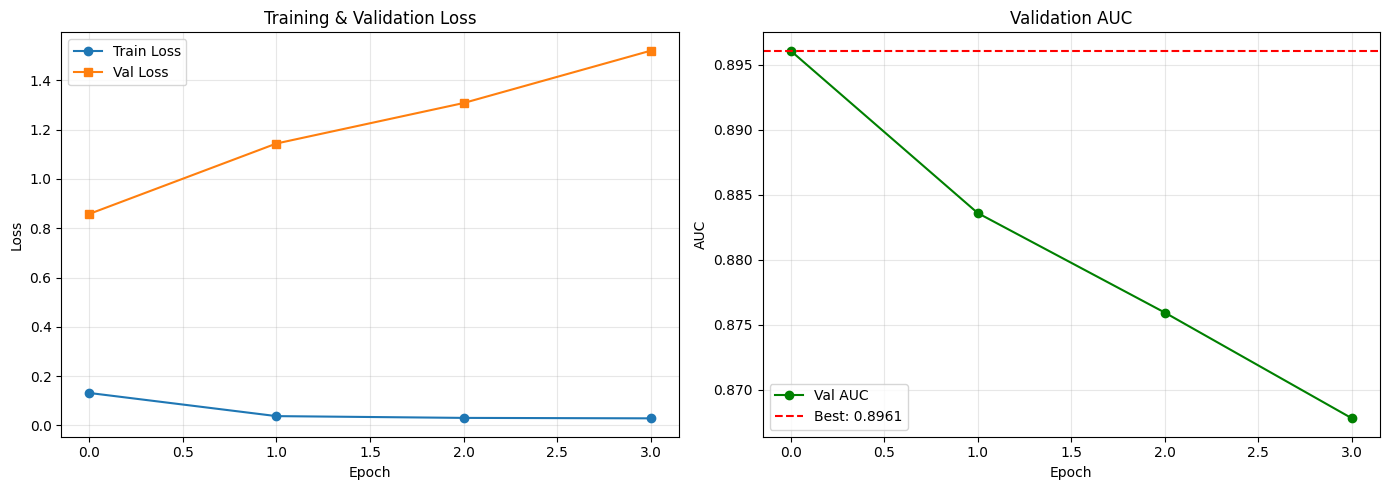

📊 Saved training curves to training_curves.png


In [20]:
# ============================================================
# CELL 19: Plot Training Curves
# ============================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AUC
ax2.plot(history['val_auc'], label='Val AUC', marker='o', color='green')
ax2.axhline(y=best_auc, color='r', linestyle='--', label=f'Best: {best_auc:.4f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.set_title('Validation AUC')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(P.WORKING / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Saved training curves to training_curves.png")

In [21]:
# ============================================================
# CELL 20: Generate Submission
# ============================================================

# Load best model
model.load_state_dict(torch.load(P.WORKING / 'best_model.pt'))
model.eval()

print("\n🔮 Generating test predictions...")

all_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predict'):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with autocast():
            logits = model(batch)
        
        probs = torch.sigmoid(logits).cpu().numpy()
        all_preds.extend(probs)

# Create submission
submission = pd.DataFrame({
    'ID': np.arange(len(all_preds)),
    'Task1&2': all_preds
})

# Save
submission.to_csv(P.WORKING / 'prediction.csv', index=False)

print(f"\n✅ Submission saved: {P.WORKING / 'prediction.csv'}")
print(f"Shape: {submission.shape}")
print("\nFirst 10 rows:")
print(submission.head(10))

print("\n🎯 Task 2 Complete!")


🔮 Generating test predictions...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Predict:   0%|          | 0/93 [00:00<?, ?it/s]

/tmp/ipykernel_24/602844683.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



✅ Submission saved: /kaggle/working/mmctr_task1_v2/prediction.csv
Shape: (379142, 2)

First 10 rows:
   ID   Task1&2
0   0  0.010010
1   1  0.999512
2   2  0.586914
3   3  0.000242
4   4  0.000009
5   5  0.053314
6   6  0.906250
7   7  1.000000
8   8  0.012482
9   9  0.455811

🎯 Task 2 Complete!


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
